[View in Colaboratory](https://colab.research.google.com/github/iegorval/neural_nets/blob/master/CorrectedBinary.ipynb)

# Getting Ready
Prepare the files and the libraries for the experiment.

In [37]:
# Installs
!pip install -U -q PyDrive

In [38]:
# Imports
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM, Input, Activation, Dense, TimeDistributed, Dropout, BatchNormalization
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import Callback, LearningRateScheduler
import keras.backend as K
import keras.utils as utils
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import re
from io import StringIO
from math import exp

In [39]:
# PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Get all files from the root folder
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

In [40]:
# Get the .pow files 
pow_files = [(file['title'], file['id'], re.sub(r'_[0-9]+|.pow', '', file['title'])) 
             for file in file_list if file['title'].find('.pow')>0]
num_examples = len(pow_files)
# Get the categories
categories = list(set([file_info[2] for file_info in pow_files]))
# Get the dictionary of the categories
num_cat = len(categories)
categories_dict = {categories[i] : i for i in range(num_cat)}

In [41]:
print(categories_dict)

{'flat': 0, 'black_rough': 1, 'grass_flat': 2, 'grass_rough': 3, 'black_flat': 4, 'cubes': 5}


# Utils
Helper functions.

In [42]:
def to_one_hot(category):
  assert category < num_cat
  one_hot = np.zeros((num_cat))
  one_hot[category] = 1
  return one_hot

In [43]:
def from_one_hot(one_hot):
  for i in range(len(one_hot)):
    if one_hot[i]==1:
      return i

# Model
Recurrent Neural Network model in Keras.

In [44]:
def get_model1():
  model = Sequential()
  model.add(LSTM(32, return_sequences=False, input_shape=(max_length//skip,1)))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [45]:
def get_model2():
  model = Sequential()
  model.add(LSTM(64, return_sequences=False, input_shape=(max_length//skip,1)))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [46]:
def get_model3():
  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(LSTM(32))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [47]:
def get_model4():
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(LSTM(64))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [48]:
def get_model5():
  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(Dropout(0.4))
  model.add(LSTM(32))
  model.add(Dropout(0.4))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [49]:
def get_model6():
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(Dropout(0.4))
  model.add(LSTM(64))
  model.add(Dropout(0.4))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

# Data
Preprocess the data: combine all the examples together and introduce padding where necessary. Split the longest time series in the several smaller ones.

In [0]:
# Make a list of dataframes along with their corresponding classes
list_df = list()
for pow_file in pow_files:
  if pow_file[0].find('cubes')==0 or pow_file[0].find('flat')==0:
    f = drive.CreateFile({'id': pow_file[1]})
    content = f.GetContentString()
    dataIO = StringIO(content)
    df = pd.read_csv(dataIO, header=None, sep=' ')
    list_df.append((df, to_one_hot(categories_dict[pow_file[2]])))

In [50]:
# Make a list of dataframes along with their corresponding classes
list_df = list()
for pow_file in pow_files:
  if pow_file[0].find('black_rough')==0 or pow_file[0].find('grass_rough')==0 \
     or pow_file[0].find('black_flat')==0 or pow_file[0].find('grass_flat')==0:
    f = drive.CreateFile({'id': pow_file[1]})
    content = f.GetContentString()
    dataIO = StringIO(content)
    df = pd.read_csv(dataIO, header=None, sep=' ')
    list_df.append((df, to_one_hot(categories_dict[pow_file[2]])))

In [51]:
# Split the biggest examples into separate sequences
max_length = 100
long_dfs = [i for i in range(len(list_df)) if list_df[i][0].shape[0] > max_length]
list_df_cut = list(list_df)
max_examples = 3000
examples_categories = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for i in reversed(long_dfs):
  df = list_df_cut[i][0]
  category = from_one_hot(list_df_cut[i][1])
  for g, split_df in df.groupby(np.arange(len(df)) // max_length):
    if examples_categories[category] < max_examples:
      list_df_cut.append((split_df, list_df[i][1]))
      examples_categories[category] += 1
  del list_df_cut[i]

In [52]:
print(examples_categories)
print(categories_dict)

{0: 0, 1: 215, 2: 179, 3: 161, 4: 112, 5: 0}
{'flat': 0, 'black_rough': 1, 'grass_flat': 2, 'grass_rough': 3, 'black_flat': 4, 'cubes': 5}


In [53]:
# Get only the measurements for current
currents_list = [(np.transpose(np.array(df_cut[0][[2]])), df_cut[1]) for df_cut in list_df_cut]
currents_long = [(np.transpose(currents[0]), currents[1]) for currents in currents_list if currents[0].shape[1]>=max_length]
currents_no_labels = [currents[0] for currents in currents_long]

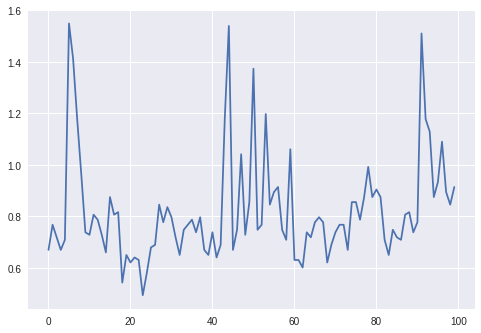

In [54]:
plt.plot(currents_no_labels[0])

In [55]:
# Skip some timesteps
skip = 1
currents_skip = list()
for currents in currents_no_labels:
  currents_skip.append(list())
  i = 0
  while True:
    currents_skip[-1].append(currents[i])
    i += skip
    if i >= len(currents):
      break

In [56]:
# Get training data into a numpy matrix
full_x = np.stack(currents_skip, axis=0)
# Get training labels
full_y = np.array([currents[1] for currents in currents_long])

In [57]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [59]:
#full_x_norm = utils.normalize(full_x, axis=0, order=2)
x_shuffled, y_shuffled = unison_shuffled_copies(full_x, full_y)

In [60]:
full_y_labels = [from_one_hot(one_hot) for one_hot in y_shuffled]
full_y_binary = [0 if label==categories_dict['black_flat'] or label==categories_dict['black_rough'] else 1 for label in full_y_labels]

In [61]:
print(full_y_binary)

[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 

[0. 0. 0. 0. 1. 0.]


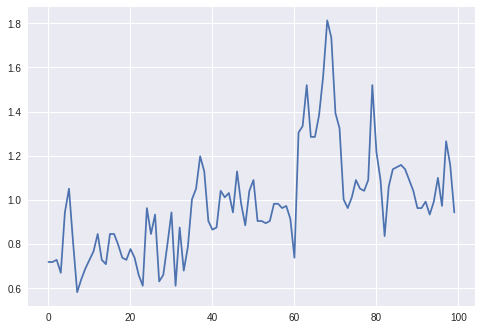

In [63]:
# Training set
train_x = x_shuffled[100:]
train_y = full_y_binary[100:]
# Test set
test_x = x_shuffled[:100]
test_y = full_y_binary[:100]

plt.plot(x_shuffled[1])
print(full_y[1])

# Experiment

In [64]:
model = get_model1()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [65]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

In [66]:
def exp_decay(epoch):
    initial_lrate = 0.01
    k = 0.1
    lrate = initial_lrate * exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
callbacks_list = [lrate]

In [67]:
model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [0]:
history = model.fit(train_x, train_y, epochs=500, batch_size=16, shuffle=True)

Epoch 1/500
555/555 [==============================] - 2s 4ms/step - loss: 0.6959 - acc: 0.4955
Epoch 2/500
555/555 [==============================] - 2s 4ms/step - loss: 0.6941 - acc: 0.4901
Epoch 3/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6919 - acc: 0.5261
Epoch 4/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6916 - acc: 0.5081
Epoch 5/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6903 - acc: 0.5351
Epoch 6/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6892 - acc: 0.5369
Epoch 7/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6864 - acc: 0.5676
Epoch 8/500
128/555 [=====>........................] - ETA: 1s - loss: 0.6847 - acc: 0.5547

555/555 [==============================] - 2s 3ms/step - loss: 0.6715 - acc: 0.6036
Epoch 9/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6651 - acc: 0.6090
Epoch 10/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6547 - acc: 0.6450
Epoch 11/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6544 - acc: 0.6342
Epoch 12/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6574 - acc: 0.6126
Epoch 13/500
555/555 [==============================] - 2s 4ms/step - loss: 0.6589 - acc: 0.6198
Epoch 14/500
555/555 [==============================] - 2s 4ms/step - loss: 0.6536 - acc: 0.6306
Epoch 15/500
192/555 [=========>....................] - ETA: 1s - loss: 0.6527 - acc: 0.6198

555/555 [==============================] - 2s 3ms/step - loss: 0.6515 - acc: 0.6270
Epoch 16/500
555/555 [==============================] - 2s 4ms/step - loss: 0.6563 - acc: 0.6324
Epoch 17/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6514 - acc: 0.6396
Epoch 18/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6502 - acc: 0.6414
Epoch 19/500
555/555 [==============================] - 2s 4ms/step - loss: 0.6488 - acc: 0.6414
Epoch 20/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6483 - acc: 0.6577
Epoch 21/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6475 - acc: 0.6432
Epoch 22/500
224/555 [===========>..................] - ETA: 1s - loss: 0.6125 - acc: 0.6920

555/555 [==============================] - 2s 3ms/step - loss: 0.6420 - acc: 0.6468
Epoch 23/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6413 - acc: 0.6450
Epoch 24/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6514 - acc: 0.6378
Epoch 25/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6350 - acc: 0.6595
Epoch 26/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6415 - acc: 0.6523
Epoch 27/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6414 - acc: 0.6631
Epoch 28/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6459 - acc: 0.6306
Epoch 29/500
192/555 [=========>....................] - ETA: 1s - loss: 0.6424 - acc: 0.6510

555/555 [==============================] - 2s 3ms/step - loss: 0.6396 - acc: 0.6541
Epoch 30/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6359 - acc: 0.6685
Epoch 31/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6402 - acc: 0.6450
Epoch 32/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6306 - acc: 0.6703
Epoch 33/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6444 - acc: 0.6486
Epoch 34/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6265 - acc: 0.6685
Epoch 35/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6477 - acc: 0.6414
Epoch 36/500
192/555 [=========>....................] - ETA: 1s - loss: 0.6305 - acc: 0.6458

555/555 [==============================] - 2s 3ms/step - loss: 0.6300 - acc: 0.6649
Epoch 37/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6320 - acc: 0.6541
Epoch 38/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6340 - acc: 0.6559
Epoch 39/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6284 - acc: 0.6667
Epoch 40/500
555/555 [==============================] - 2s 4ms/step - loss: 0.6318 - acc: 0.6703
Epoch 41/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6473 - acc: 0.6468
Epoch 42/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6599 - acc: 0.6505
Epoch 43/500
160/555 [=======>......................] - ETA: 1s - loss: 0.6280 - acc: 0.6500

555/555 [==============================] - 2s 3ms/step - loss: 0.6281 - acc: 0.6649
Epoch 44/500
555/555 [==============================] - 2s 4ms/step - loss: 0.6445 - acc: 0.6685
Epoch 45/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6382 - acc: 0.6468
Epoch 46/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6391 - acc: 0.6559
Epoch 47/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6537 - acc: 0.6090
Epoch 48/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6682 - acc: 0.6036
Epoch 49/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6426 - acc: 0.6523
Epoch 50/500
256/555 [============>.................] - ETA: 1s - loss: 0.6017 - acc: 0.7148

555/555 [==============================] - 2s 3ms/step - loss: 0.6347 - acc: 0.6685
Epoch 51/500
555/555 [==============================] - 2s 3ms/step - loss: 0.6452 - acc: 0.6414
Epoch 52/500
 48/555 [=>............................] - ETA: 1s - loss: 0.5889 - acc: 0.7708

Text(0.5,0,'epoch')

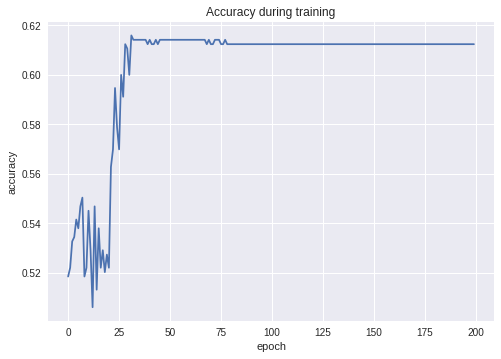

In [0]:
# Plot the accuracy during training
plt.plot(history.history['acc'])
plt.title("Accuracy during training")
plt.ylabel("accuracy")
plt.xlabel("epoch")

Text(0.5,0,'epoch')

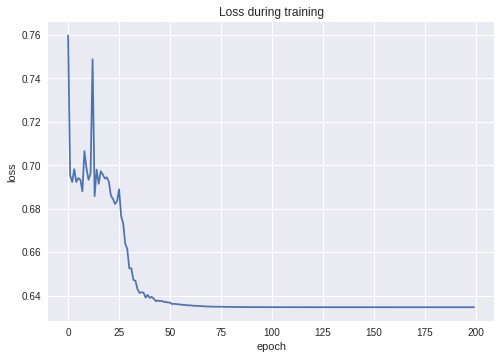

In [0]:
plt.plot(history.history['loss'])
plt.title("Loss during training")
plt.ylabel("loss")
plt.xlabel("epoch")

In [0]:
# Evalute the same model
model.evaluate(x=test_x, y=test_y)


120/120 [==============================] - 7s 58ms/step


[0.6689239184061686, 0.55]